In [1]:
import os
import numpy as np
import pylab as plt
import scipy.signal as sg
import sounddevice as sd
import pandas as pd
from time import sleep
from sklearn.model_selection import train_test_split

plt.rcParams['axes.grid'] = True

In [2]:
data_dir = '../kaggle/all'
x_global_train = np.load(os.path.join(data_dir, 'train.npz'))['x']
y_global_train = np.load(os.path.join(data_dir, 'train.npz'))['y']
x_global_test  = np.load(os.path.join(data_dir, 'test.npz'))['x']
x_train, x_test, y_train, y_test = train_test_split(x_global_train, y_global_train, shuffle=True)
fs = 16000
print(x_train.shape, y_train.shape)

(1687, 16000) (1687,)


In [3]:
for k in np.random.choice(np.arange(len(x_train)), 10):
    print(int(y_train[k]))
    sd.play(x_train[k], fs)
    sleep(1.2)

3
3
1
1
1
2
2
1
2
2


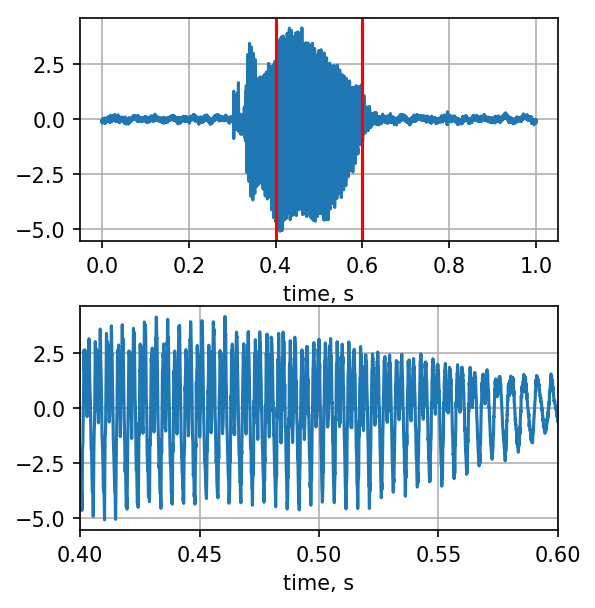

In [4]:
fig, ax = plt.subplots(2, figsize=(4,4), dpi=150)
plt.tight_layout()

x = x_train[y_train==3][0]

time = np.arange(len(x))/fs

segment = [0.4, 0.6]
ax[0].plot(time, x)
ax[0].set_xlabel('time, s')
[ax[0].axvline(b, color='r') for b in segment]
ax[1].plot(time, x)
ax[1].set_xlim(segment)
ax[1].set_xlabel('time, s')
sd.play(x, fs)

(129,) (1687, 129)


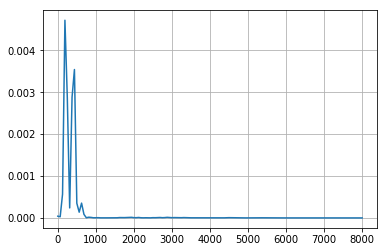

In [7]:
freq, x_spec_train = sg.welch(x_train, fs, axis=1)
print(freq.shape, x_spec_train.shape)
plt.plot(freq, x_spec_train[y_train==3][0])

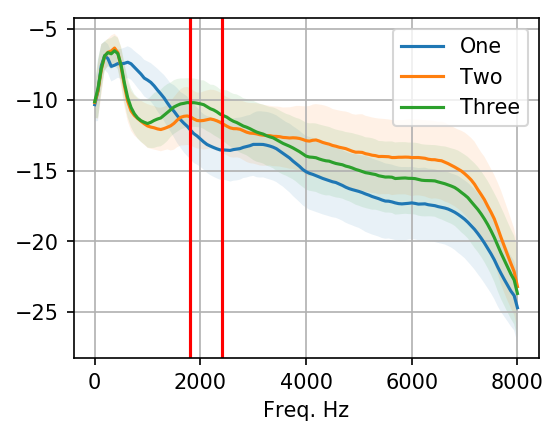

In [142]:
fig, ax = plt.subplots(1, figsize=(4,3), dpi=150)
for k in range(1, 3+1):
    specs = np.log(x_spec_train[y_train==k])
    plt.plot(freq, specs.mean(0), label=['One', 'Two', 'Three'][k-1])
    plt.fill_between(freq, specs.mean(0)-specs.std(0), specs.mean(0)+specs.std(0), alpha=0.1)
    
plt.legend()
plt.xlabel('Freq. Hz')
band = (1800, 2400)
[plt.axvline(b, color='r') for b in band]

In [143]:
def extract_features(x, band):
    
    freq, spec = sg.welch(x, fs, axis=1)
    features = spec[:, (freq>band[0]) & (freq<band[1])].mean(1).reshape(-1, 1)
    return features

In [144]:
f_train = extract_features(x_train, band)
f_test  = extract_features(x_test, band)
f_global_test = extract_features(x_global_test, band)

In [145]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

classifier = DecisionTreeClassifier()
classifier.fit(f_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [146]:

y_train_pred = classifier.predict(f_train)
y_test_pred = classifier.predict(f_test)
y_global_test_pred = classifier.predict(f_global_test)

accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(0.6532305868405454, 0.4635879218472469)

In [148]:
print('{:12s} {:12s} {:12s}'.format('prediction', 'actual', 'error'))
for k in np.random.choice(np.arange(len(x_test)), 10):
    sd.play(x_test[k], fs)
    print('{:12s} {:12s} {}'.format(str(int(y_test_pred[k])), str(int(y_test[k])), y_test_pred[k]==y_test[k]))
    sleep(1.2)


prediction   actual       error       
1            1            True
1            1            True
3            2            False
3            3            True
3            3            True
2            3            False
2            3            False
1            1            True
3            1            False
1            1            True


In [149]:
df = pd.DataFrame(data=y_global_test_pred, columns=['Category'], dtype=int)
df.to_csv('test_lecture7.csv', index_label='Id')
df

,Category
0,1
1,1
2,1
3,3
4,1
5,2
6,2
7,3
8,2
9,1
